In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple
import json 
import gc

import cv2
import PIL 

import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train_procedure, get_augmented_transforms, load_model, plot_models
from models import DenseNet

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def check_parameters():
    my_densenet = DenseNet(num_classes=1000)
    my_densenet_params = my_densenet.count_parameters()
    
    torch_densenet = torchvision.models.densenet121(pretrained=False)
    torch_densenet_params = sum(p.numel() for p in torch_densenet.parameters() if p.requires_grad)
    
    del my_densenet
    del torch_densenet
    print(f'torch parameters count: {torch_densenet_params}, my densenet parameters count: {my_densenet_params}')


In [5]:
check_parameters()

torch parameters count: 7978856, my densenet parameters count: 7978856


In [6]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [7]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(directory=TRAIN_PATH, out_path=TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(directory=VAL_PATH, out_path=VAL_LABELS_CSV_PATH)

In [8]:
train_labels, val_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH), pd.read_csv(VAL_LABELS_CSV_PATH)

mean, std = get_norm_stats(data_path=TRAIN_LABELS_CSV_PATH)

val_transform = get_transforms(mean=mean, std=std)
train_transform = get_augmented_transforms(mean=mean, std=std) if AUGMENT else get_transforms(mean=mean, std=std)

train_dataset = ImagenetteDataset(labels_csv_path=TRAIN_LABELS_CSV_PATH, transform=train_transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(labels_csv_path=VAL_LABELS_CSV_PATH, transform=val_transform)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [20]:
if 'model' in locals():
    del model
    
N_EPOCHS = 34
RESUME_TRAINING = True

model_name = 'densenet121'
epoch = 0

model = DenseNet()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

if RESUME_TRAINING:
    epoch = load_model(model, optimizer, os.path.join(SAVES_PATH, f'ckpts3/{model_name}_model.pt'))

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-8)
model.to(device);

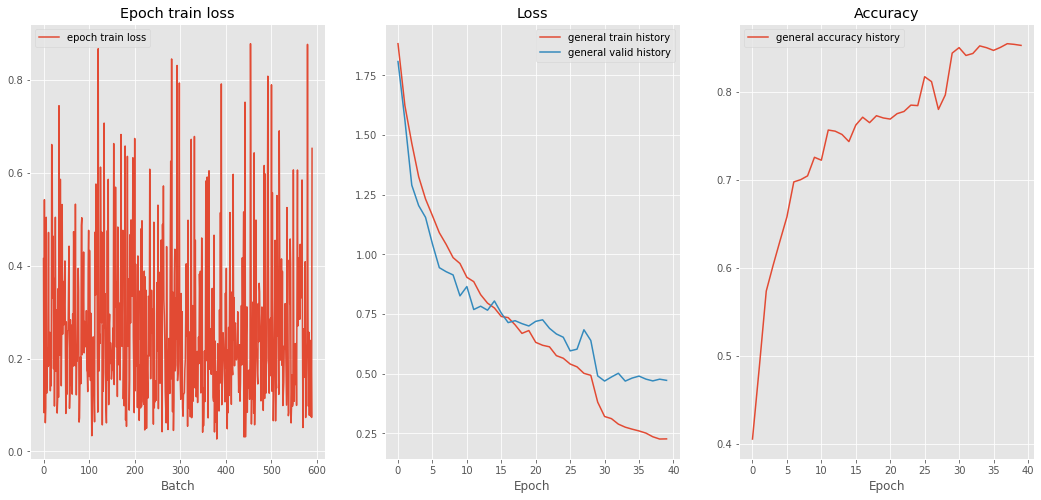

In [21]:
train_procedure(n_epochs=N_EPOCHS, model=model, train_iterator=train_dataloader, 
                val_iterator=val_dataloader, optimizer=optimizer,
                criterion=loss, saves_path=SAVES_PATH, start_epoch=epoch, 
                device=device, scheduler=scheduler, model_name=model_name)

In [ ]:
# DenseNet prediction analysis 
if 'model' in locals():
    del model 
    
model = DenseNet()
ckpt_path = "saves/ckpts3/densenet121_model.pt"
    
checkpoint = torch.load(ckpt_path, device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()

class_shot = np.zeros(10)
class_cnt = np.zeros(10)
predictions = np.array([0])
labels_true = np.array([0])
mistake_imgs = {i: [] for i in range(10)}
mistake_preds = {i: [] for i in range(10)}
mistake_labels = {i: [] for i in range(10)}
with torch.no_grad():
    for i, (imgs, labels) in enumerate(val_dataloader):
        imgs = imgs.to(device)
        labels = labels.numpy().astype(int)
        predictions_batch = model(imgs).argmax(axis=1).detach().cpu().numpy().astype(int)
        
        mistake_ids = np.where(labels != predictions_batch)[0]
        if len(mistake_ids) > 0:
            for ind in mistake_ids:
                if len(mistake_imgs[labels[ind]]) < 5:
                    mistake_imgs[labels[ind]].append(imgs[ind].clone().detach().cpu())
                    mistake_labels[labels[ind]].append(labels[ind])
                    mistake_preds[labels[ind]].append(predictions_batch[ind])
        for ind, label in enumerate(labels):
            if label == predictions_batch[ind]:
                class_shot[label] += 1
            class_cnt[label] += 1
            
        predictions = np.concatenate((predictions, predictions_batch), axis=None)
        labels_true = np.concatenate((labels_true, labels), axis=None)
        
predictions, labels_true = predictions[1:], labels_true[1:]
predictions.shape, labels_true.shape, len(mistake_imgs[0]), len(mistake_labels[0]), len(mistake_preds[0])

In [23]:
accuracy_score(labels_true, predictions)

0.8507006369426752

In [24]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]

for ind, label in enumerate(class_shot):
    print(f'accuracy of class {class_names[ind]}: {label / class_cnt[ind]}')

accuracy of class church: 0.8899755501222494
accuracy of class fish: 0.9405684754521964
accuracy of class truck: 0.8200514138817481
accuracy of class good boy: 0.9164556962025316
accuracy of class disco: 0.8823529411764706
accuracy of class chute: 0.8743589743589744
accuracy of class gas station: 0.7255369928400954
accuracy of class chainsaw: 0.7564766839378239
accuracy of class french horn: 0.8324873096446701
accuracy of class golf ball: 0.8771929824561403


In [25]:
confusion_matrix(labels_true, predictions)

array([[364,   2,   6,   2,   8,   9,   4,   7,   5,   2],
       [  2, 364,   1,   1,   2,   1,   1,   5,   2,   8],
       [ 14,   4, 319,   1,   7,   3,  17,  16,   7,   1],
       [  2,   4,   1, 362,   2,   2,   2,  17,   1,   2],
       [  8,   1,   3,   1, 315,   2,  18,   2,   2,   5],
       [ 16,   5,   8,   3,   2, 341,   5,   7,   0,   3],
       [ 27,   4,  21,   0,  31,   8, 304,  16,   2,   6],
       [ 12,  12,  12,   1,  20,   6,  17, 292,   7,   7],
       [ 12,   6,   4,   3,  11,   3,   7,  14, 328,   6],
       [ 12,   5,   1,   0,  10,   7,   3,   9,   2, 350]])

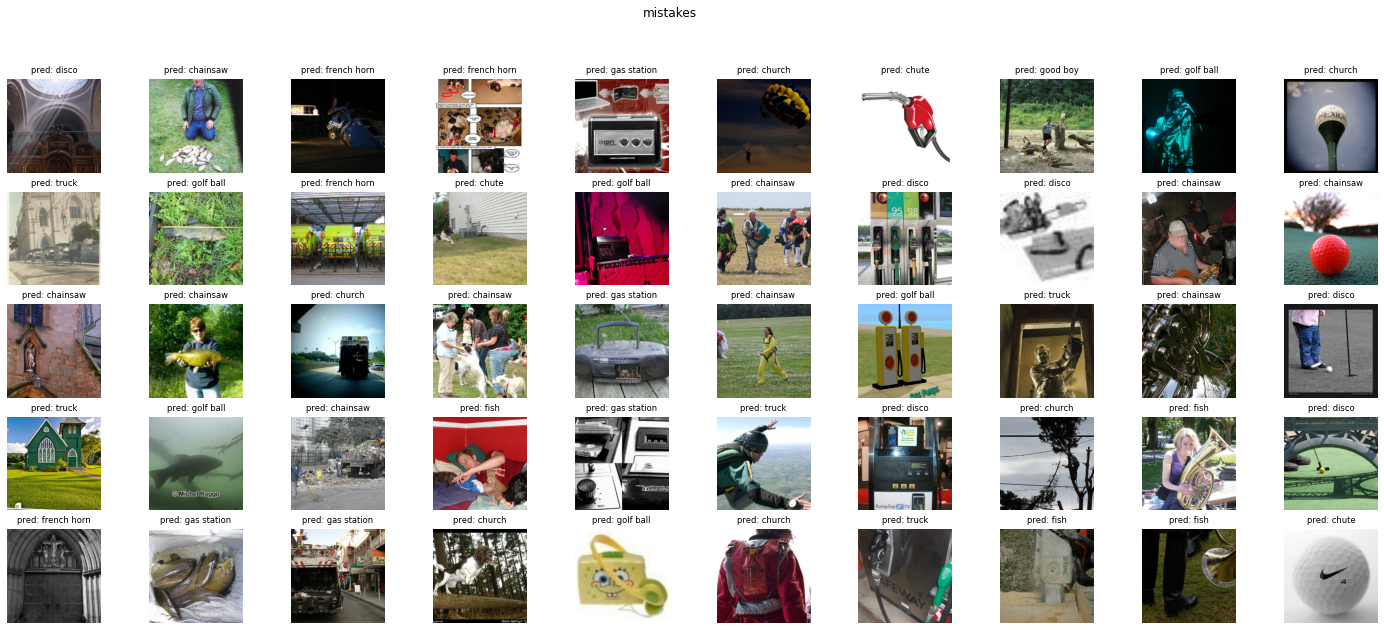

In [33]:
renorm = T.Compose(
    [
     T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
    T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
    T.ToPILImage(mode='RGB')
    ] 
    )

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(25, 10))
for i in range(10):
    labels= mistake_labels[i]
    images = mistake_imgs[i]
    preds = mistake_preds[i]
    for j in range(5):
        ax[j, i].imshow(renorm(images[j]))
        ax[j, i].set_title(f'pred: {class_names[preds[j]]}', fontsize='small')
        ax[j, i].axis('off')

plt.suptitle('mistakes')
plt.show();